# Sequential Parameter Optimization
## `river` Hyperparameter Tuning: Holt-Winters


In [1]:
pip list | grep spotPython

spotPython                                0.0.1
Note: you may need to restart the kernel to use updated packages.


In [2]:
# import sys
# !{sys.executable} -m pip install --upgrade build
# !{sys.executable} -m pip install --upgrade --force-reinstall spotRiver

# Example: Holt-Winters Hyperparameter

In [3]:
import numpy as np
from math import inf
from spotRiver.fun.hyperriver import HyperRiver
from spotPython.spot import spot
from scipy.optimize import shgo
from scipy.optimize import direct
from scipy.optimize import differential_evolution
import matplotlib.pyplot as plt
from river import anomaly
from river import datasets
from river import metrics
from river import time_series
from river import compose
from river import preprocessing
from river import linear_model
from matplotlib import pyplot
import matplotlib.pyplot as plt
import datetime as dt
import pandas as pd
import numpy as np

### 1 Example from River - The Objective Function

* This is the Holt-Winters example taken from [https://riverml.xyz/0.14.0/api/time-series/HoltWinters/](https://riverml.xyz/0.14.0/api/time-series/HoltWinters/)
* It is used to check whether the implementation can be executed.
* Finally, the objective function is added.

In [4]:
from river import datasets
from river import metrics
from river import time_series

dataset = datasets.AirlinePassengers()

model = time_series.HoltWinters(
     alpha=0.3,
     beta=0.1,
     gamma=0.6,
     seasonality=12,
     multiplicative=True
 )

metric = metrics.MAE()

res = time_series.evaluate(
     dataset,
     model,
     metric,
     horizon=12
 )

y = res.metrics
z = 0.0
for i in range(len(y)):
        z = z + y[i].get()
# Now we can define the objective function value:
z/len(y)

28.76684843302738

### 2 The `fun_hw` from `spotPython`'s `HyperRiver` class

* x0. `alpha`: Smoothing parameter for the level.
* x1. `beta`: Smoothing parameter for the trend.
* x2. `gamma`: Smoothing parameter for the seasonality.
* x3. `seasonality`: The number of periods in a season. For instance, this should be 4 for quarterly data, and 12 for yearly data.
* x4. `multiplicative`: Whether or not to use a multiplicative formulation.

In [5]:
from spotRiver.fun.hyperriver import HyperRiver
from spotRiver.data import AirlinePassengers
from numpy import sqrt
from numpy import spacing
eps = sqrt(spacing(1))
lower = np.array([0.2, 0.0125, 0.2, 0, 0])
upper = np.array([0.75, 0.15, 0.7, 12, 1])
var_type=["num", "num", "num", "int", "factor"]
dataset = AirlinePassengers()
fun_control = {"horizon": 12,
               "grace_period": None,
               "data": dataset,
               }
fun = HyperRiver(123).fun_hw

### 3 Run the `Spot` Optimizer

* We have chosen `fun_evals = inf` and `max_time = 1`, so that `Spot` runs 1 minute.

In [6]:
spot_hw = spot.Spot(fun=fun,
                   lower = lower,
                   upper = upper,
                   fun_evals = inf,
                   fun_repeats = 1,
                   max_time = 1,
                   noise = False,
                   tolerance_x = np.sqrt(np.spacing(1)),
                   var_type=var_type,
                   infill_criterion = "y",
                   n_points = 1,
                   seed=123,
                   log_level = 50,
                   show_models= False,
                   show_progress= True,
                   fun_control = fun_control,
                   design_control={"init_size": 15,
                                   "repeats": 1},
                   surrogate_control={"noise": False,
                                      "cod_type": "norm",
                                      "min_theta": -4,
                                      "max_theta": 3,
                                      "n_theta": 5,
                                      "model_optimizer": differential_evolution,
                                      "model_fun_evals": 1000,
                                      })
spot_hw.run()

spotPython tuning: [##########] 100.00% Done...


### 4 Results

In [7]:
spot_hw.print_results()

min y: 27.614009793923685
min X: [[ 0.58063433  0.03162479  0.44032473 12.          1.        ]]


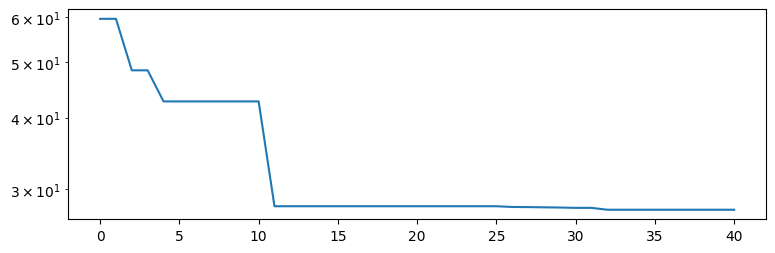

In [8]:
spot_hw.plot_progress(log_y=True)

In [9]:
spot_hw.print_importance()

Importance relative to the most important parameter:
Parameter 0 :  0.011033704388048071
Parameter 1 :  0.41783636169467037
Parameter 2 :  0.043779952833128126
Parameter 3 :  100.0
Parameter 4 :  0.0042944214351911805


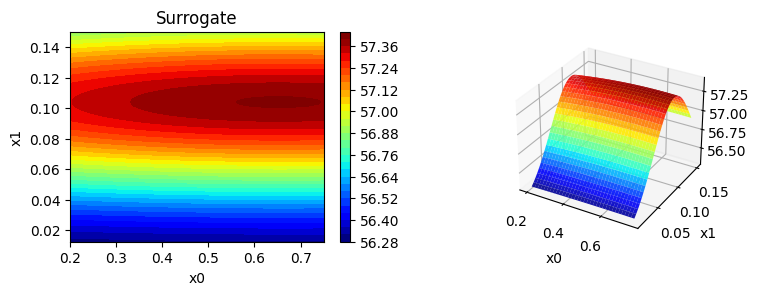

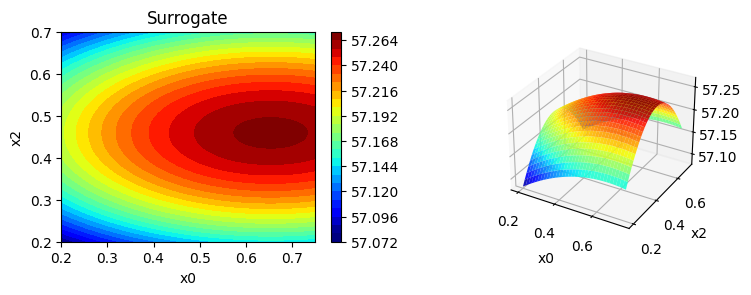

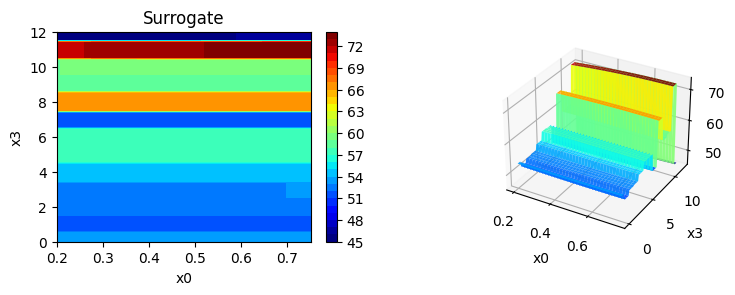

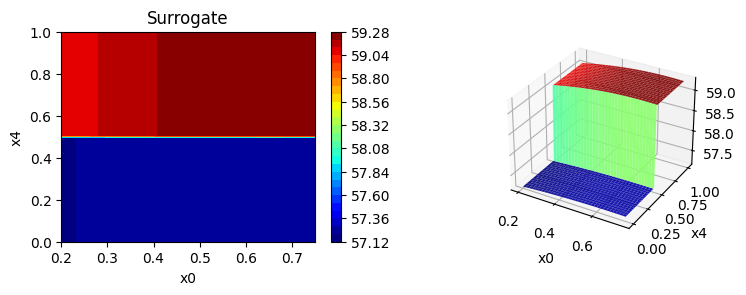

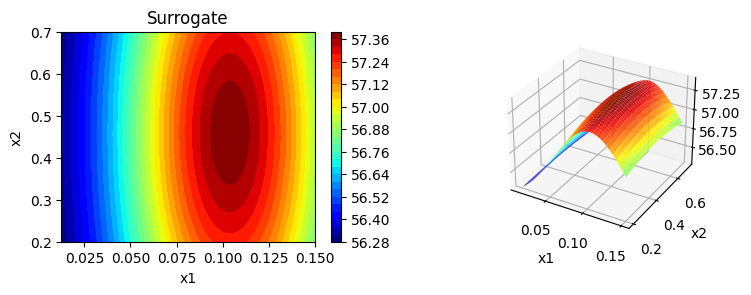

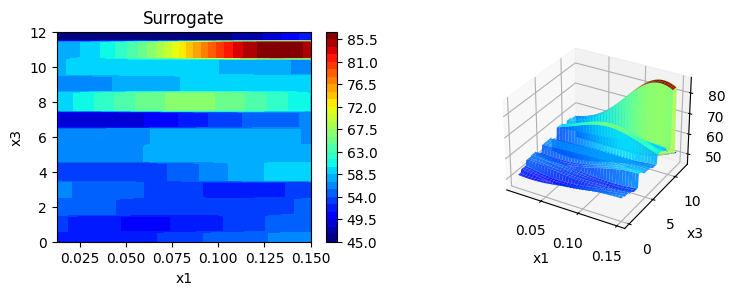

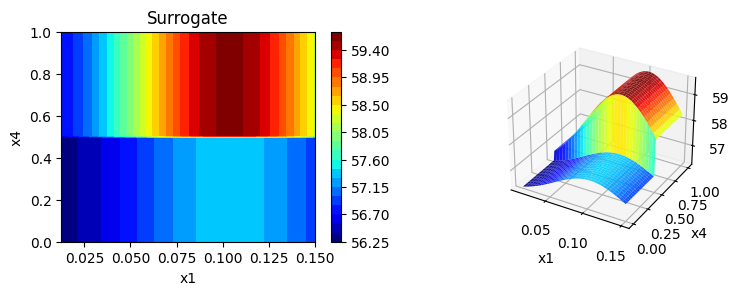

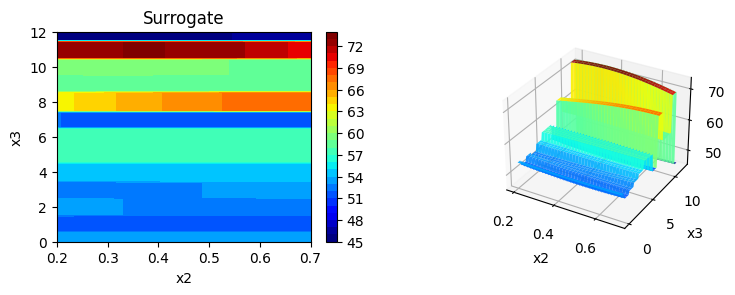

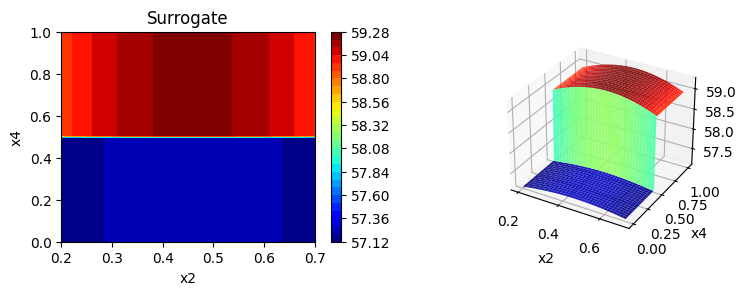

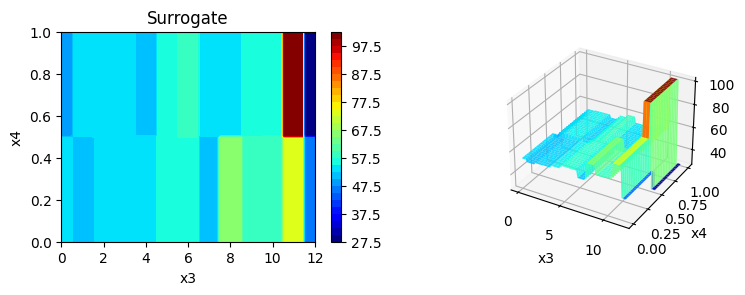

In [10]:
n = spot_hw.k
for i in range(n-1):
    for j in range(i+1, n):
        spot_hw.plot_contour(i=i, j=j, min_z=None, max_z=None)